# Model Building

## Attaching Resources

### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from IPython.display import Audio
from sklearn.metrics import accuracy_score
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

### Adding Dataset

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
len(paths)

2800

In [4]:
paths[:5]

['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [7]:
df['label'] = df['label'].replace('ps', 'pleasant surprise')

In [8]:
df['label'].value_counts()

label
angry                400
disgust              400
fear                 400
happy                400
neutral              400
pleasant surprise    400
sad                  400
Name: count, dtype: int64

In [9]:
labels = np.array(df['label'].value_counts().index)

### Audio feature extraction method

In [10]:
def extract_mfcc(filename):
     y, sr = librosa.load(filename, duration=3, offset=0.5)
     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
     return mfcc

In [11]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255327e+00,  2.02101365e-01,
        7.27551103e-01,  1.31773746e+00,  2.88633752e+00,  2.85579085e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169914e+01,  2.03489304e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722193e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486832e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896181e+00,  9.31392384e+00,  2.08914995e+00, -1.90649164e+00],
      dtype=float32)

In [12]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [13]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [14]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [15]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [16]:
label_index_mapping = {i: label for i, label in enumerate(enc.categories_[0])}
print(label_index_mapping)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'pleasant surprise', 6: 'sad'}


## Splitting The Data Into Traning and Testing Dataset

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [18]:
print(x_train.shape)
print(x_test.shape)

(2240, 40, 1)
(560, 40, 1)


In [19]:
print(y_train.shape)
print(y_test.shape)

(2240, 7)
(560, 7)


### Creating the LSTM Model

In [20]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [21]:
history = model.fit(x_train, y_train, validation_split= 0.2, epochs = 50, batch_size=64)

Epoch 1/50
28/28 [==============================] - 7s 183ms/step - loss: 1.3767 - accuracy: 0.4699 - val_loss: 0.6981 - val_accuracy: 0.7634
Epoch 2/50
28/28 [==============================] - 4s 130ms/step - loss: 0.6416 - accuracy: 0.7427 - val_loss: 0.3236 - val_accuracy: 0.8884
Epoch 3/50
28/28 [==============================] - 4s 129ms/step - loss: 0.3668 - accuracy: 0.8739 - val_loss: 0.2400 - val_accuracy: 0.9196
Epoch 4/50
28/28 [==============================] - 3s 124ms/step - loss: 0.2519 - accuracy: 0.9224 - val_loss: 0.1729 - val_accuracy: 0.9420
Epoch 5/50
28/28 [==============================] - 4s 129ms/step - loss: 0.2061 - accuracy: 0.9358 - val_loss: 0.1043 - val_accuracy: 0.9598
Epoch 6/50
28/28 [==============================] - 3s 122ms/step - loss: 0.2097 - accuracy: 0.9325 - val_loss: 0.1285 - val_accuracy: 0.9554
Epoch 7/50
28/28 [==============================] - 3s 111ms/step - loss: 0.1335 - accuracy: 0.9581 - val_loss: 0.1014 - val_accuracy: 0.9598
Epoch 

In [22]:
y_pred = model.predict(x_test)

18/18 [==============================] - 1s 33ms/step


In [23]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [24]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)

In [25]:
print(accuracy*100,"% accuracy")

98.03571428571428 % accuracy


### Ploting Loss 

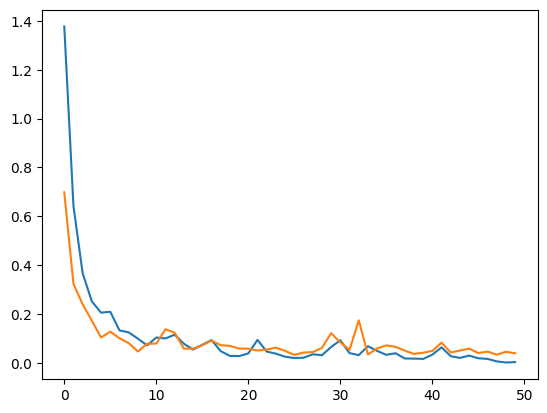

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### ploting Accuracy

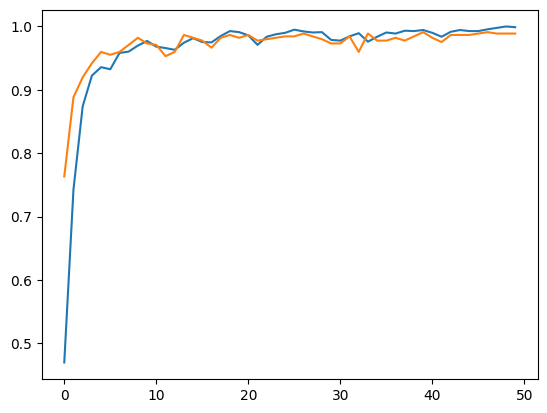

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

### Predicting Model

In [28]:
new_paths = ['TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 'TESS Toronto emotional speech set data/OAF_Fear/OAF_voice_fear.wav',
 'TESS Toronto emotional speech set data/YAF_angry/YAF_shack_angry.wav',
 'TESS Toronto emotional speech set data/YAF_disgust/YAF_sail_disgust.wav',
 'TESS Toronto emotional speech set data/YAF_happy/YAF_jail_happy.wav',
 'TESS Toronto emotional speech set data/YAF_sad/YAF_red_sad.wav']

pred_df = pd.DataFrame({'speech':new_paths})

In [29]:
pred_X_mfcc = pred_df['speech'].apply(lambda x: extract_mfcc(x))
pred_X = [x for x in pred_X_mfcc]
pred_X = np.array(pred_X)
pred_X = np.expand_dims(pred_X, -1)

In [30]:
model.predict(pred_X)[0]

1/1 [==============================] - 0s 33ms/step


array([1.9445733e-07, 1.8959684e-08, 9.9999940e-01, 1.8160913e-08,
       2.9502777e-07, 5.8010368e-08, 1.8436493e-08], dtype=float32)

In [31]:
for i in model.predict(pred_X):
    print(labels[i.argmax()])

1/1 [==============================] - 0s 34ms/step
fear
fear
angry
disgust
happy
sad


## Creating Model

In [32]:
model.save('audio.h5')